In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import mlflow
import mlflow.sklearn
import warnings
warnings.filterwarnings('ignore')


In [4]:
df = pd.read_csv('C:/Users/Admin/Documents/1.All Projects in guvi/SmartPremium Insurance Prediction/data/train.csv')
df.head()


,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,...,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,1068382,38.0,Female,5958.0,Divorced,2.0,Master's,Unemployed,4.104554,Rural,...,1.0,17.0,NaN,7.0,2023-08-07 15:21:39.173834,Poor,Yes,Weekly,Condo,1208.0
1,629817,23.0,Female,3801.0,Divorced,4.0,PhD,Self-Employed,38.700068,Suburban,...,2.0,4.0,673.0,4.0,2023-03-22 15:21:39.185215,Average,Yes,Daily,House,1607.0
2,793873,25.0,Female,60569.0,Divorced,3.0,Master's,Unemployed,19.934356,Rural,...,NaN,19.0,313.0,5.0,2024-02-21 15:21:39.257696,Average,No,Weekly,Condo,493.0
3,768934,46.0,Male,38394.0,Married,1.0,PhD,Employed,18.915866,Urban,...,NaN,10.0,818.0,8.0,2019-11-22 15:21:39.288099,Poor,Yes,Daily,House,1419.0
4,802684,62.0,Female,29853.0,Single,0.0,PhD,Unemployed,40.058471,Suburban,...,NaN,17.0,659.0,6.0,2021-11-29 15:21:39.146733,Good,No,Rarely,House,1475.0


In [5]:
print(df.info())
print(df.describe())
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21870 entries, 0 to 21869
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    21870 non-null  int64  
 1   Age                   21570 non-null  float64
 2   Gender                21870 non-null  object 
 3   Annual Income         21072 non-null  float64
 4   Marital Status        21494 non-null  object 
 5   Number of Dependents  19884 non-null  float64
 6   Education Level       21870 non-null  object 
 7   Occupation            15310 non-null  object 
 8   Health Score          20529 non-null  float64
 9   Location              21870 non-null  object 
 10  Policy Type           21870 non-null  object 
 11  Previous Claims       15229 non-null  float64
 12  Vehicle Age           21870 non-null  float64
 13  Credit Score          19322 non-null  float64
 14  Insurance Duration    21870 non-null  float64
 15  Policy Start Date  

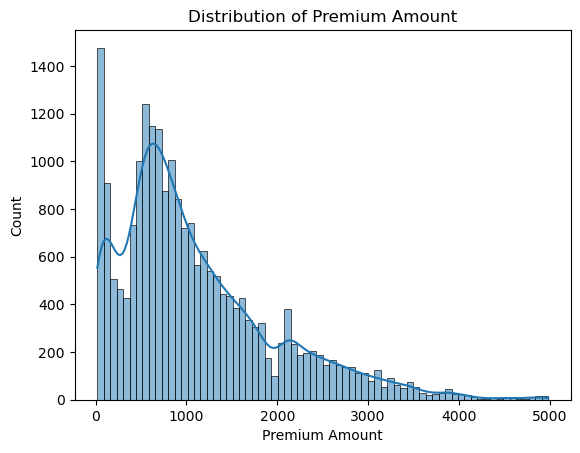

In [6]:
sns.histplot(df['Premium Amount'], kde=True)
plt.title('Distribution of Premium Amount')
plt.show()


In [7]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

X = df.drop("Premium Amount", axis=1)
y = df["Premium Amount"]

num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object']).columns.tolist()

num_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))  
])

preprocessor = ColumnTransformer(transformers=[
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])


In [10]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import mlflow
import mlflow.sklearn
import numpy as np

# Define numerical and categorical features
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Drop high-cardinality columns from categorical features
high_card_cols = [col for col in cat_features if X[col].nunique() > 100]
cat_features = [col for col in cat_features if col not in high_card_cols]

# Define transformers
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

# Define the ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

# Build pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

# MLflow tracking
mlflow.set_experiment("SmartPremium_InsurancePrediction")

with mlflow.start_run():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    mlflow.log_metric("RMSE", rmse)
    print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2 Score: {r2:.2f}")



2025/03/14 12:25:29 INFO mlflow.tracking.fluent: Experiment with name 'SmartPremium_InsurancePrediction' does not exist. Creating a new experiment.


RMSE: 872.27, MAE: 675.59, R2 Score: -0.00


# Visualization

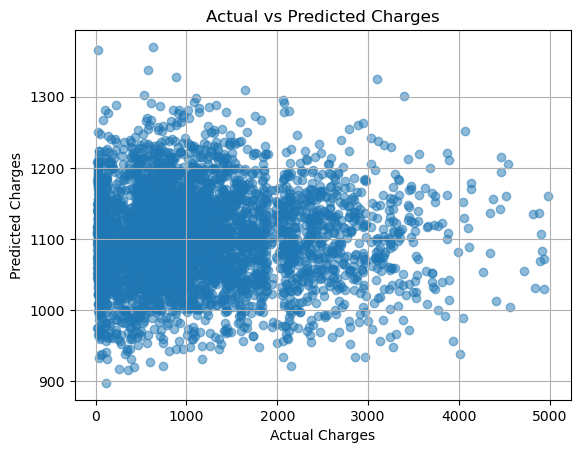

In [12]:


plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Actual vs Predicted Charges")
plt.grid(True)
plt.show()


In [13]:
# Predictions to a CSV

predictions_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})
predictions_df.to_csv('insurance_predictions.csv', index=False)
print(predictions_df)

       Actual  Predicted
3246   1073.0      968.5
8692     20.0     1066.0
7534   1298.0     1198.5
5841   1656.0     1095.0
8979    917.0     1281.5
...       ...        ...
8451   1893.0     1056.0
6930     97.0     1067.5
12745  2446.0     1072.5
1274    567.0     1095.5
6933    526.0     1017.0

[4374 rows x 2 columns]


In [14]:
from sklearn.ensemble import RandomForestRegressor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])
print(pipeline)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['id', 'Age', 'Annual Income',
                                                   'Number of Dependents',
                                                   'Health Score',
                                                   'Previous Claims',
                                                   'Vehicle Age',
                                                   'Credit Score',
                                                   'Insurance Duration']),
                                                 ('cat',
                        

In [30]:
from sklearn.pipeline import make_pipeline
import joblib
import os

# Create a final pipeline combining preprocessing + model
final_pipeline = make_pipeline(preprocessor, LinearRegression())
final_pipeline.fit(X_train, y_train)

# Create the folder if not exists
os.makedirs("model", exist_ok=True)

# Save the pipeline (this includes preprocessing + model)
joblib.dump(final_pipeline, "model/insurance_model.pkl")

print("Model saved successfully as 'model/insurance_model.pkl'")


Model saved successfully as 'model/insurance_model.pkl'
